### 1. Import libraies 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os

%matplotlib inline


import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
np.bool = np.bool_


from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option("display.precision", 2)
from IPython.display import Image

from sklearn.preprocessing import OneHotEncoder



### 2.Import Data

In [38]:
# training data without labels
features = pd.read_csv('./Data/dengue_features_train.csv')#, index_col=[0,1,2])
label = pd.read_csv('./data/dengue_labels_train.csv')#,index_col=[0,1,2])
test = pd.read_csv('./data/dengue_features_test.csv')#,index_col=[0,1,2])

#training data with labels
df=pd.merge(features, label, how='left', on =['city', 'year', 'weekofyear'])

In [3]:
df.head(2)

# Create an instance of One-hot-encoder
encoder = OneHotEncoder()
# Passing encoded columns
enc_data = pd.DataFrame(encoder.fit_transform(df[['city']]).toarray())
enc_data.columns = ['sj', 'iq']

# Merge with main data
df = df.join(enc_data)
#new_df=new_df.drop('city', axis=1)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.8,295.9,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.9,296.4,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.7,22.2,8.6,5


In [4]:
# testing data
# Passing encoded columns
enc_data_test = pd.DataFrame(encoder.fit_transform(test[['city']]).toarray())
enc_data_test.columns = ['iq', 'sj']

# Merge with main data
test = test.join(enc_data_test)
#test=test.drop('city', axis=1)


### 3. Understand the data & data preprocessing
* Total 20 Features 

1. NOAA's GHCN daily climate data weather station measurements (start from here we need to look at the data by each city)
* station_max_temp_c – Maximum temperature
* station_min_temp_c – Minimum temperature
* station_avg_temp_c – Average temperature
* station_precip_mm – Total precipitation
* station_diur_temp_rng_c – Diurnal temperature range

2. PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
* precipitation_amt_mm – Total precipitation

3. NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
* reanalysis_sat_precip_amt_mm – Total precipitation
* reanalysis_dew_point_temp_k – Mean dew point temperature
* reanalysis_air_temp_k – Mean air temperature
* reanalysis_relative_humidity_percent – Mean relative humidity
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity
* reanalysis_precip_amt_kg_per_m2 – Total precipitation
* reanalysis_max_air_temp_k – Maximum air temperature
* reanalysis_min_air_temp_k – Minimum air temperature
* reanalysis_avg_temp_k – Average air temperature
* reanalysis_tdtr_k – Diurnal temperature range

4. Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements (monitoring vegetation and crop conditions)
* ndvi_se – Pixel southeast of city centroid
* ndvi_sw – Pixel southwest of city centroid
* ndvi_ne – Pixel northeast of city centroid
* ndvi_nw – Pixel northwest of city centroid

- we have city, year, weekofyear, we dont need repeated week information, we can drop the "week_start_date"
- there is 1 categorical variables in the table, city, we can focus on how to analyze the numerical variables and deal with the missing value and preprocessing before feeding to the models

#### 3.1 Observations
- In the 20 features  climate data, only Satellite vegatation index(NVDI) values are normalized
- The temperture values are in different units, Kelvin & Celsius. 
- These features all have some missing values, we should fill the NAs since it is a time series problem and also not a large dataset; 

#### Two methonds:
1. forwardfill – ffill : Fill NA/NaN values by propagating the last valid observation to next valid
    - ffill is more appropriate when the missing values are at the beginning of the dataset, while bfill is more appropriate when the missing values are at the end of the dataset. Since our data doesn't have missing data in the beginning row, we can use ffill. 
    - temperature values: if we fill by Mean/Median, it might not make sense, since temperature varies with datetype data,the values should be similar with the most recent value around to that point
2. use Interpolate() Method with limit parameter e.g linear 

In [8]:
df.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,sj,iq
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.8,295.9,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.4,20.0,16.0,4,0.0,1.0
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.9,296.4,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.7,22.2,8.6,5,0.0,1.0
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,298.88,295.43,300.5,297.3,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.2,22.8,41.4,4,0.0,1.0


In [9]:
#df_1["x_axis"] = df["city"] + df["week_start_date"]#df["year"].map(str)+'-'+ df["weekofyear"].map(str) 

In [39]:
df_1=df.copy()

# San Juan cases vs time 
import plotly.express as px
fig_sj = px.line(df_1[df_1.city =='sj'], x='week_start_date', y="total_cases", title = 'SJ historical cases')
fig_sj.show()


In [14]:
fig_iq = px.line(df_1[df_1.city =='iq'], x='week_start_date', y="total_cases", title = 'IQ historical cases')
fig_iq.show()

### 3.2 check NAs
- Check the na values in our training/testing features; drop the columns if it contains a lot of null value, use different methods to fill the na
- here we found that there are 20 columns has NAs, especially the ndvi_ne feature (~ 13.3% for the train, ~ 10.3% for the test) is it worth to fill the missing value for this variable? we can discuss it later during feature selection part 
- now we need to understand what are they represent of, then we can fill the value


In [19]:
# Check the na values in our training features
train_percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_train = pd.DataFrame({'column_name':  df.columns,
                                 'percent_missing': train_percent_missing})

test_percent_missing = test.isnull().sum() * 100 / len(test)
missing_value_test = pd.DataFrame({'column_name': test.columns,
                                 'percent_missing': test_percent_missing})

missing_value_train
missing_value_test

,column_name,percent_missing
city,city,0.00
year,year,0.00
weekofyear,weekofyear,0.00
week_start_date,week_start_date,0.00
ndvi_ne,ndvi_ne,13.32
ndvi_nw,ndvi_nw,3.57
ndvi_se,ndvi_se,1.51
ndvi_sw,ndvi_sw,1.51
precipitation_amt_mm,precipitation_amt_mm,0.89
reanalysis_air_temp_k,reanalysis_air_temp_k,0.69


,column_name,percent_missing
city,city,0.00
year,year,0.00
weekofyear,weekofyear,0.00
week_start_date,week_start_date,0.00
ndvi_ne,ndvi_ne,10.34
ndvi_nw,ndvi_nw,2.64
ndvi_se,ndvi_se,0.24
ndvi_sw,ndvi_sw,0.24
precipitation_amt_mm,precipitation_amt_mm,0.48
reanalysis_air_temp_k,reanalysis_air_temp_k,0.48


### Time to split the data by city and work on the preprocessing 
### 3.3 fill NAs
- ffill
- iq_train_interpolate with linear method

In [40]:
# forward fill the data 
df = df.interpolate(method='linear', limit_direction="forward")#df.fillna(method='ffill')
test = test.interpolate(method='linear', limit_direction="forward") #test.fillna(method='ffill')


# linear interpolate data to fill NAs
#df_interpolate=df.interpolate(method='linear', limit_direction="forward")
#df_interpolate.describe()

#test_interpolate=test.interpolate(method='linear', limit_direction="forward")
#test_interpolate.describe()

In [170]:
# average NOAA's NCEP Climate Forecast System Reanalysis temperature related variable

df['avg_reanalysis'] = df[['reanalysis_air_temp_k','reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                                    'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']].mean(axis = 1)

#average_nvdi variable
df['avg_ndvi'] = df[['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']].mean(axis = 1)


# average NOAA's NCEP Climate Forecast System Reanalysis temperature related variable
test['avg_reanalysis'] = test[['reanalysis_air_temp_k','reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                                    'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']].mean(axis = 1)

#average_nvdi variable
test['avg_ndvi'] = test[['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']].mean(axis = 1)

### Total cases is not highly correlated with the variables here, however some features are highly correlated 


<Figure size 1600x900 with 0 Axes>

Text(0.5, 1.0, 'San Juan Variable Correlations')

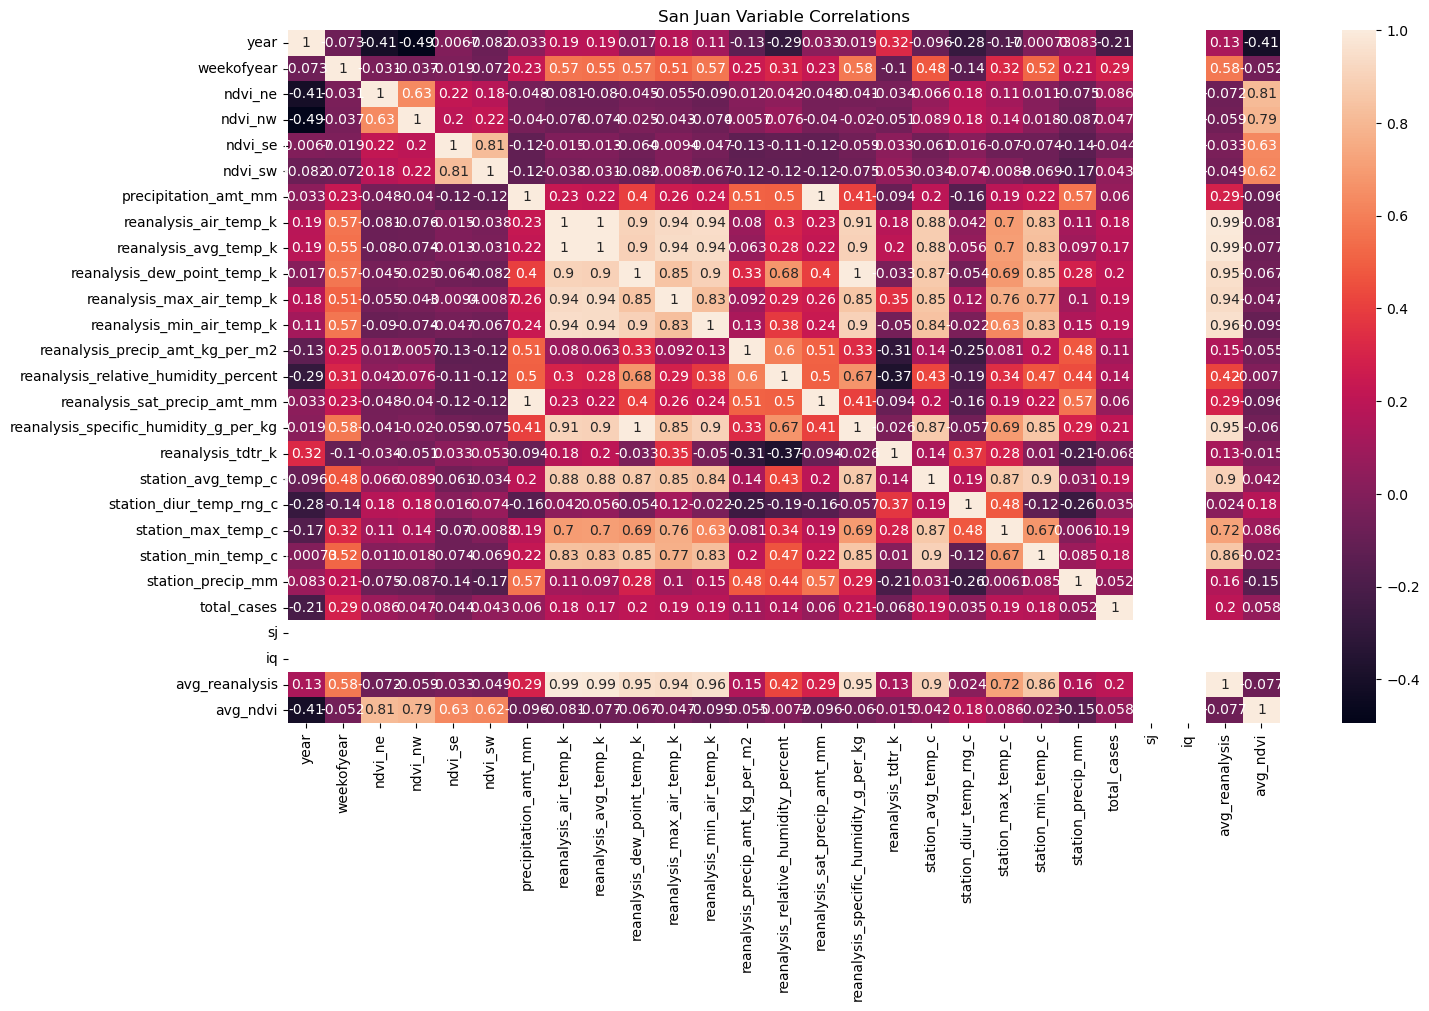

In [27]:
sj_correlations =  df[df.city =='sj'].drop(['city','week_start_date'], axis=1).corr()
# plot san juan
plt.figure(figsize = (16,9))
sj_corr_heat = sns.heatmap(sj_correlations, annot = True)
plt.title('San Juan Variable Correlations')

<Figure size 1600x900 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'San Juan Variables vs Total Cases')

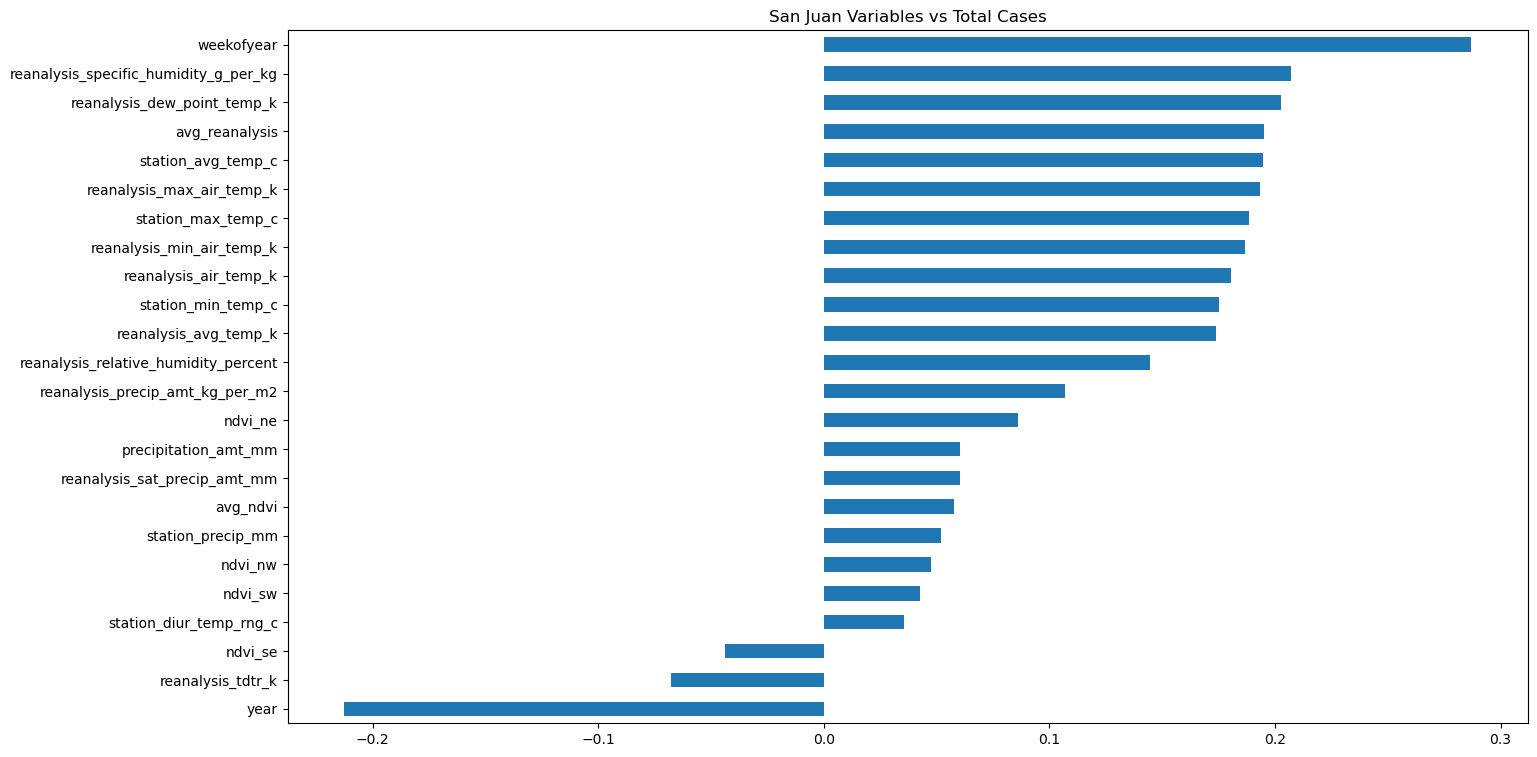

In [29]:
plt.figure(figsize = (16,9))
(sj_correlations
     .total_cases
     .drop(['total_cases', 'sj', 'iq']) 
     .sort_values(ascending=True)
     .plot
     .barh())
plt.title('San Juan Variables vs Total Cases')

<Figure size 1600x900 with 0 Axes>

Text(0.5, 1.0, 'Iquitos Variable Correlations')

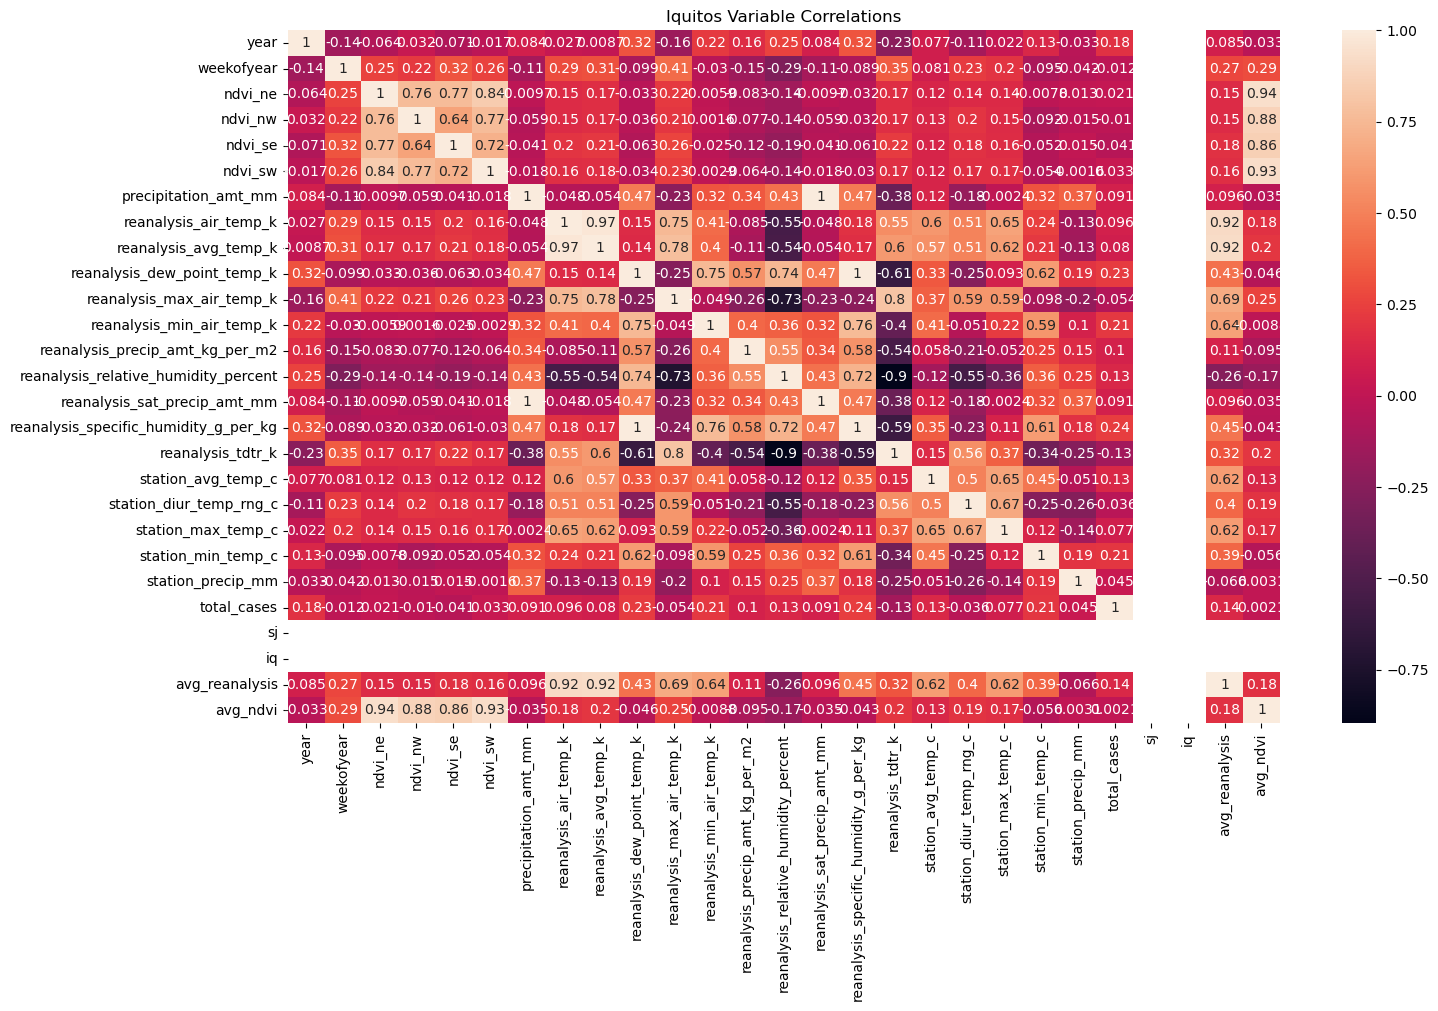

In [30]:
plt.figure(figsize = (16,9))
iq_correlations = df[df.city =='iq'].drop(['city','week_start_date'], axis=1).corr()
# plot san juan
iq_corr_heat = sns.heatmap(iq_correlations, annot = True)
plt.title('Iquitos Variable Correlations')

<Figure size 1600x900 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Iquitos Variables vs Total Cases')

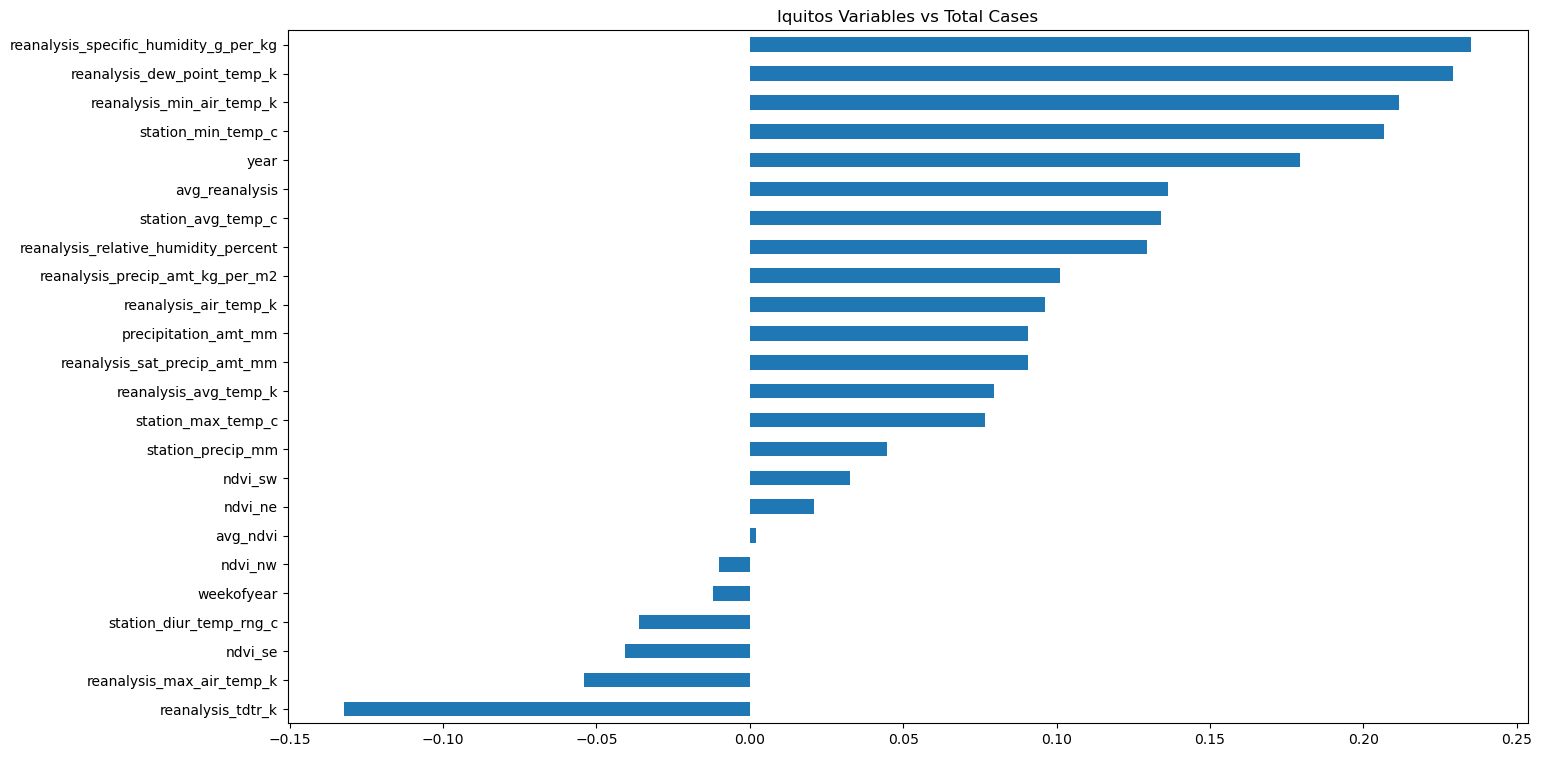

In [31]:
plt.figure(figsize = (16,9))
(iq_correlations
     .total_cases
     .drop(['total_cases', 'sj', 'iq']) 
     .sort_values(ascending=True)
     .plot
     .barh())
plt.title('Iquitos Variables vs Total Cases')

### Features highly correlated variables with total cases are: 
For San Juan city: weekofyear, reanalysis_specific_humidity_g_per_kg, reanalysis_dew_point_temp_k, avg_reanalysis, station_avg_temp_c and other temperature variables, also precipitation variables;         

1. Most highly correlated variables are temperature related, which make sense, mosquitos like:
- They prefer to live in areas that are around 70-80 degrees Fahrenheit (21-27C). So even though cold weather doesn't kill mosquitoes, they definitely don't like it. At around 60 degrees(15C), they become lethargic and they are incapable of functioning at temperatures below 50 degrees (10C)

2. Mosquitoes breed in water, so 
- Wet environment, so higher the humidity higher the total cases
- Precipitation is also important feature


For Iquitos: the correlation of weather is more important to predict the total cases, weekofyear seems not really helping with the prediction

### Since we saw there are some correlation between variables 
#### lets get rid of the highly correlated variables

In [73]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

norm_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm',
       'avg_reanalysis', 'avg_ndvi']

minmax_cols = ['year', 'weekofyear']#,'month','season'] # keep in [0,1]

def preproc_data(df):
    df_new = df.copy()
    # Normalize weather data 
    df_new[norm_cols] = StandardScaler().fit_transform(df_new[norm_cols])

    # Min max standardizate year and week no but within (0,1)
    df_new[minmax_cols] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_new[minmax_cols])
    return df_new

In [100]:
df_1 = preproc_data(df).drop(['week_start_date'], axis=1)
test_1 = preproc_data(test).drop(['week_start_date'], axis=1)

In [101]:
def drop_columns(df, treshold):
    corr_matrix=df.corr().abs()
    upper=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop=[col for col in upper.columns if any(upper[col]>treshold)]
    #new_df = df.drop(to_drop,axis=1)
    return to_drop 


In [169]:
drop_columns(df_1[df_1.city=='iq'].drop('city', axis=1), 0.9)

['reanalysis_avg_temp_k',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'avg_reanalysis',
 'avg_ndvi']

In [102]:
sj_col_keep=['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
                'weekofyear',
             'avg_reanalysis','avg_ndvi',
               'total_cases']

### SJ model 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


X_sj = df_1[df_1.city =='sj'][sj_col_keep].drop('total_cases', axis=1)
y_sj = df_1[df_1.city =='sj'].total_cases

X_sj_train, X_sj_test, y_sj_train, y_sj_val  = train_test_split(X_sj, y_sj, test_size= 0.15)


In [107]:
# GridSearch on random forest regressor 
param_grid = {  'bootstrap': [True], 
                'max_depth': [5, 10, None], 
                'max_features': ['auto', 'log2','sqrt'], 
                'n_estimators': [10, 50, 100, 150, 200],
                'min_samples_split': [2, 5, 10, 15, 100],
                'min_samples_leaf' : [1, 2, 5, 10]
}

rfr_gc = RandomForestRegressor()

sj_rf = GridSearchCV(estimator = rfr_gc, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True, refit = True)

sj_rf.fit(X_sj_train, y_sj_train)


/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True)

In [83]:
pred_rfr_sj = sj_rf.predict(X_sj_test)
print(mean_absolute_error(y_sj_val, pred_rfr_sj))


15.67453577652882


Text(0.5, 0.98, 'Dengue Predicted Cases vs. Actual Cases in San Juan')

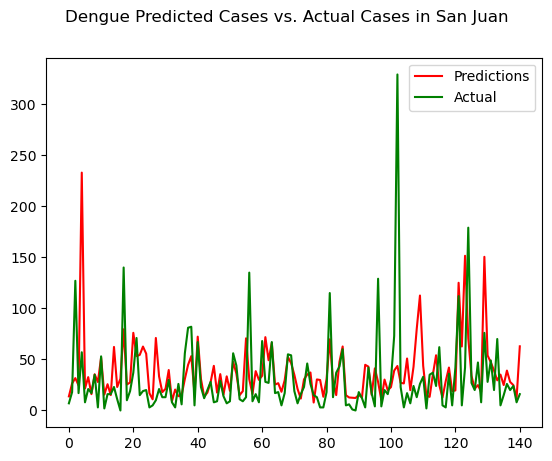

In [109]:
# Plot the predictions
y_validation = pd.DataFrame(y_sj_val).reset_index()
y_validation['Prediction'] = pred_rfr_sj

plt.plot(y_validation.Prediction, color="red", label="Predictions")
plt.plot(y_validation.total_cases, color='green',label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases in San Juan")
plt.legend(loc='upper right')
plt.show()


<Axes: >

<Axes: >

Text(0.5, 0.98, 'Dengue Predicted Cases vs. Actual Cases in San Juan')

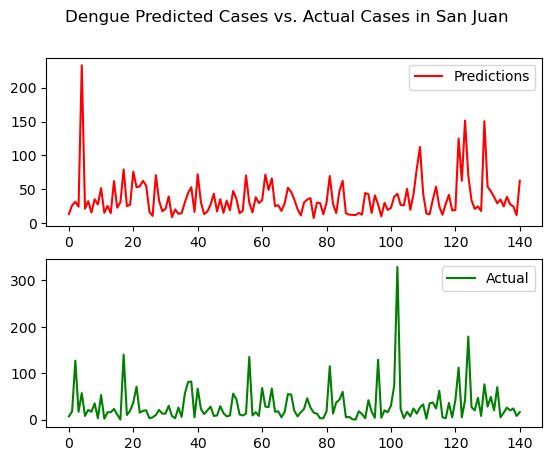

In [110]:

# compare two predictions by figures
plt.subplot(211)
plt.plot(y_validation.Prediction, color="red", label="Predictions")
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(y_validation.total_cases, color='green',label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases in San Juan")
plt.legend()
plt.show()

In [125]:
### SJ testing 

test_sj_col_keep = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
                'weekofyear',
             'avg_reanalysis','avg_ndvi']
sj_test = test_1[test_1.city == 'sj']
sj_test = sj_test[test_sj_col_keep]

### SJ prediction 
sj_prd = sj_rf.predict(sj_test)


### IQ model 

In [127]:

iq_col_keep = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
             'avg_reanalysis','avg_ndvi']

X_iq = df_1[df_1.city =='iq'][iq_col_keep]#.drop('total_cases', axis=1)
y_iq = df_1[df_1.city =='iq'].total_cases

X_iq_train, X_iq_test, y_iq_train, y_iq_val  = train_test_split(X_iq, y_iq, test_size= 0.15)


In [128]:
# GridSearch on random forest regressor 
param_grid = {  'bootstrap': [True], 
                'max_depth': [5, 10, None], 
                'max_features': ['auto', 'log2','sqrt'], 
                'n_estimators': [10, 50, 100, 150, 200],
                'min_samples_split': [2, 5, 10, 15, 100],
                'min_samples_leaf' : [1, 2, 5, 10]
}

rfr_gc = RandomForestRegressor()

iq_rf = GridSearchCV(estimator = rfr_gc, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True, refit = True)

iq_rf.fit(X_iq_train, y_iq_train)


/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as 

/Users/shutingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [10, 50, 100, 150, 200]},
             return_train_score=True)

In [129]:
pred_rfr_iq = iq_rf.predict(X_iq_test)
print(mean_absolute_error(y_iq_val, pred_rfr_iq))


5.168969716915654


Text(0.5, 0.98, 'Dengue Predicted Cases vs. Actual Cases in Iquitos')

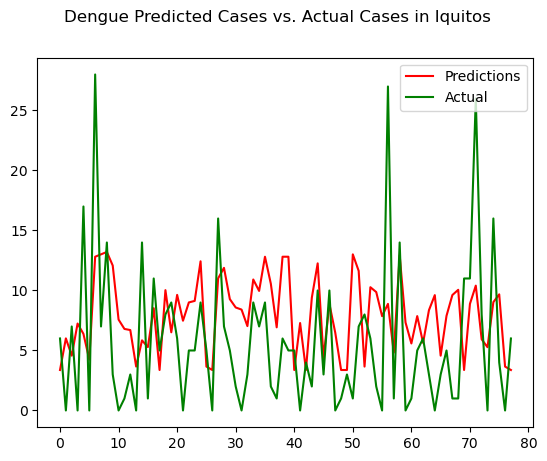

In [130]:
# Plot the predictions
y_validation = pd.DataFrame(y_iq_val).reset_index()
y_validation['Prediction'] = pred_rfr_iq

plt.plot(y_validation.Prediction, color="red", label="Predictions")
plt.plot(y_validation.total_cases, color='green',label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases in Iquitos")
plt.legend(loc='upper right')
plt.show()


In [132]:
### IQ testing 

test_iq_col_keep = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
             'avg_reanalysis','avg_ndvi']
iq_test = test_1[test_1.city == 'iq']
iq_test = iq_test[test_iq_col_keep]

### IQ prediction 
iq_prd = iq_rf.predict(iq_test)


In [157]:

pred=pd.read_csv('./Data/submission_format.csv', index_col=[0,1,2])
#pred = pred.set_index(['city','year','weekofyear']).drop('total_cases', axis=1)


pred['total_cases'] = pd.concat([pd.DataFrame(sj_prd), pd.DataFrame(iq_prd)], ignore_index=True).to_numpy()
pred= pred[['total_cases']].round(0).astype(int)
pred

total_cases
city year weekofyear             
sj   2008 18                   11
          19                   12
          20                   25
          21                   13
          22                   11
...                           ...
iq   2013 22                    8
          23                    5
          24                    5
          25                    3
          26                    3

[416 rows x 1 columns]

In [158]:
pred.to_csv('./Output/random_forest_results.csv')

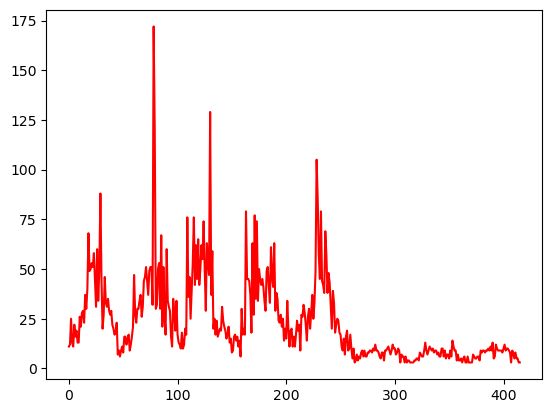

In [165]:
plt.plot(pred.reset_index().total_cases, color="red", label="Predictions")


In [ ]:
# MAE 26.0769